# USING THREADING INSTEAD OF SEQUENTIAL

# Libraries

In [ ]:
# %pip install keyboard
# %pip install mss
# %pip install numpy
# %pip install matplotlib
# %pip install opencv-python

import pyautogui as py
import pygetwindow as gw

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import PIL as ImageGrab

import keyboard

import os
import math
import time
import numpy
from mss import mss
import cv2
import numpy as np
import time
import pydirectinput
import threading
from datetime import datetime
# %pip install line_profiler
from line_profiler import LineProfiler

import mss.tools  # Using mss.tools for safer access

# Edge Detection

In [1]:
import cv2 # Import the OpenCV library to enable computer vision
import numpy as np # Import the NumPy scientific computing library
import matplotlib.pyplot as plt # Used for plotting and error checking
 
def binary_array(array, thresh, value=0):
  """
  Return a 2D binary array (mask) in which all pixels are either 0 or 1
     
  :param array: NumPy 2D array that we want to convert to binary values
  :param thresh: Values used for thresholding (inclusive)
  :param value: Output value when between the supplied threshold
  :return: Binary 2D array...
           number of rows x number of columns = 
           number of pixels from top to bottom x number of pixels from
             left to right 
  """
  if value == 0:
    # Create an array of ones with the same shape and type as 
    # the input 2D array.
    binary = np.ones_like(array) 
         
  else:
    # Creates an array of zeros with the same shape and type as 
    # the input 2D array.
    binary = np.zeros_like(array)  
    value = 1
 
  # If value == 0, make all values in binary equal to 0 if the 
  # corresponding value in the input array is between the threshold 
  # (inclusive). Otherwise, the value remains as 1. Therefore, the pixels 
  # with the high Sobel derivative values (i.e. sharp pixel intensity 
  # discontinuities) will have 0 in the corresponding cell of binary.
  binary[(array >= thresh[0]) & (array <= thresh[1])] = value
 
  return binary
 
def blur_gaussian(channel, ksize=3):
  """
  Implementation for Gaussian blur to reduce noise and detail in the image
     
  :param image: 2D or 3D array to be blurred
  :param ksize: Size of the small matrix (i.e. kernel) used to blur
                i.e. number of rows and number of columns
  :return: Blurred 2D image
  """
  return cv2.GaussianBlur(channel, (ksize, ksize), 0)
         
def mag_thresh(image, sobel_kernel=3, thresh=(0, 255)):
  """
  Implementation of Sobel edge detection
 
  :param image: 2D or 3D array to be blurred
  :param sobel_kernel: Size of the small matrix (i.e. kernel) 
                       i.e. number of rows and columns
  :return: Binary (black and white) 2D mask image
  """
  # Get the magnitude of the edges that are vertically aligned on the image
  sobelx = np.absolute(sobel(image, orient='x', sobel_kernel=sobel_kernel))
         
  # Get the magnitude of the edges that are horizontally aligned on the image
  sobely = np.absolute(sobel(image, orient='y', sobel_kernel=sobel_kernel))
 
  # Find areas of the image that have the strongest pixel intensity changes
  # in both the x and y directions. These have the strongest gradients and 
  # represent the strongest edges in the image (i.e. potential lane lines)
  # mag is a 2D array .. number of rows x number of columns = number of pixels
  # from top to bottom x number of pixels from left to right
  mag = np.sqrt(sobelx ** 2 + sobely ** 2)
 
  # Return a 2D array that contains 0s and 1s   
  return binary_array(mag, thresh)
 
def sobel(img_channel, orient='x', sobel_kernel=3):
  """
  Find edges that are aligned vertically and horizontally on the image
     
  :param img_channel: Channel from an image
  :param orient: Across which axis of the image are we detecting edges?
  :sobel_kernel: No. of rows and columns of the kernel (i.e. 3x3 small matrix)
  :return: Image with Sobel edge detection applied
  """
  # cv2.Sobel(input image, data type, prder of the derivative x, order of the
  # derivative y, small matrix used to calculate the derivative)
  if orient == 'x':
    # Will detect differences in pixel intensities going from 
        # left to right on the image (i.e. edges that are vertically aligned)
    sobel = cv2.Sobel(img_channel, cv2.CV_64F, 1, 0, sobel_kernel)
  if orient == 'y':
    # Will detect differences in pixel intensities going from 
    # top to bottom on the image (i.e. edges that are horizontally aligned)
    sobel = cv2.Sobel(img_channel, cv2.CV_64F, 0, 1, sobel_kernel)
 
  return sobel
 
def threshold(channel, thresh=(128,255), thresh_type=cv2.THRESH_BINARY):
  """
  Apply a threshold to the input channel
     
  :param channel: 2D array of the channel data of an image/video frame
  :param thresh: 2D tuple of min and max threshold values
  :param thresh_type: The technique of the threshold to apply
  :return: Two outputs are returned:
             ret: Threshold that was used
             thresholded_image: 2D thresholded data.
  """
  # If pixel intensity is greater than thresh[0], make that value
  # white (255), else set it to black (0)
  return cv2.threshold(channel, thresh[0], thresh[1], thresh_type)


# Sliding Window

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Create edge detection module
class EdgeDetection:
    def threshold(self, img, thresh=(0, 255)):
        binary = np.zeros_like(img)
        binary[(img >= thresh[0]) & (img <= thresh[1])] = 255
        return True, binary

    def blur_gaussian(self, img, ksize=3):
        return cv2.GaussianBlur(img, (ksize, ksize), 0)

    def mag_thresh(self, img, sobel_kernel=3, thresh=(0, 255)):
        sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        gradmag = np.sqrt(sobelx**2 + sobely**2)
        scale_factor = np.max(gradmag)/255
        gradmag = (gradmag/scale_factor).astype(np.uint8)
        binary_output = np.zeros_like(gradmag)
        binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 255
        return binary_output

edge = EdgeDetection()
filename = 'D:/Thinkin in programming/Metopen/my_game_screenshots/screenshot_4.png'
 
class Lane:
  """
  Represents a lane on a road.
  """
  def __init__(self, orig_frame):
    """
      Default constructor
         
    :param orig_frame: Original camera image (i.e. frame)
    """
    self.orig_frame = orig_frame

    # This will hold an image with the lane lines       
    self.lane_line_markings = None

    # Previous polynomial coefficients
    self.prev_left_fit = None
    self.prev_right_fit = None
 
    # This will hold the image after perspective transformation
    self.warped_frame = None
    self.transformation_matrix = None
    self.inv_transformation_matrix = None
 
    # (Width, Height) of the original video frame (or image)
    self.orig_image_size = self.orig_frame.shape[::-1][1:]
 
    width = self.orig_image_size[0]
    height = self.orig_image_size[1]
    self.width = width
    self.height = height
     
    ''' Static ROI points.
      This ROI are based on the screen dimensions of 1920 x 1080 pixels. 
      The roi must satisfy the game screen dimensions.
    
    '''
    # self.roi_points = np.float32([
    #         (634, 457),   # Top-left
    #         (1266, 457),  # Top-right
    #         (1700, 600),  # Bottom-right
    #         (200, 600)    # Bottom-left
    # ])

    # ''' for width": 1270, "height": 813 screen resolution '''
    # self.roi_points = np.float32([
    #       (419, 344),  # Top-left
    #       (837, 344),  # Top-right
    #       (1124, 452), # Bottom-right
    #       (132, 452)   # Bottom-left
    #   ])
    
    ''' for 800 x 600 screen resolution '''
    self.roi_points = np.float32([
        (266, 200),  # Top-left
        (532, 200),  # Top-right
        (700, 300),  # Bottom-right
        (100, 300)  # Bottom-left
    ])
    
    """
    Calculate ROI points based on screen dimensions
    Returns points in clockwise order: top-left, top-right, bottom-right, bottom-left
    """ 
    # # # Define points as percentages of width and height
    # self.roi_points = np.float32([
    #     (self.width * 0.25, self.height * 0.5),   # Top-left (25% from left, 50% down)
    #     (self.width * 0.75, self.height * 0.5),   # Top-right (75% from left, 50% down)
    #     (self.width * 0.85, self.height * 0.9),   # Bottom-right (85% from left, 90% down)
    #     (self.width * 0.15, self.height * 0.9)    # Bottom-left (15% from left, 90% down)
    #     ])
    
    # The desired corner locations  of the region of interest
    # after we perform perspective transformation.
    # Assume image width of 600, padding == 150.
    self.padding = int(0.25 * width) # padding from side of the image in pixels

    self.desired_roi_points = np.float32([
      [self.padding, 0], # Top-left corner
      [self.padding, self.orig_image_size[1]], # Bottom-left corner         
      [self.orig_image_size[
        0]-self.padding, self.orig_image_size[1]], # Bottom-right corner
      [self.orig_image_size[0]-self.padding, 0] # Top-right corner
    ]) 
         
    # Histogram that shows the white pixel peaks for lane line detection
    self.histogram = None
         
    # Sliding window parameters
    # no of windows
    self.no_of_windows = 10

    # window size
    self.margin = int((1/12) * width)  # Window width is +/- margin
    self.minpix = int((1/24) * width)  # Min no. of pixels to recenter window
         
    # Best fit polynomial lines for left line and right line of the lane
    self.left_fit = None
    self.right_fit = None
    self.left_lane_inds = None
    self.right_lane_inds = None
    self.ploty = None
    self.left_fitx = None
    self.right_fitx = None
    self.leftx = None
    self.rightx = None
    self.lefty = None
    self.righty = None
         
    # Pixel parameters for x and y dimensions
    self.YM_PER_PIX = 10.0 / 1000 # meters per pixel in y dimension
    self.XM_PER_PIX = 3.7 / 781 # meters per pixel in x dimension
         
    # Radii of curvature and offset
    self.left_curvem = None
    self.right_curvem = None
    self.center_offset = None
 
  def calculate_car_position(self, print_to_terminal=False):
    """
    Calculate the position of the car relative to the center
         
    :param: print_to_terminal Display data to console if True       
    :return: Offset from the center of the lane
    """
    # Assume the camera is centered in the image.
    # Get position of car in centimeters
    # In warped space (800x600), car is assumed at bottom center of ROI
    car_location = (self.desired_roi_points[2][0] + self.desired_roi_points[3][0]) / 2
 
    # Lane bottoms in warped space (green lines)
    height = self.warped_frame.shape[0]  # 600
    bottom_left = self.left_fitx[-1]  # Last point of left green line
    bottom_right = self.right_fitx[-1]  # Last point of right green line

    # center of the lane in warped space 
    center_lane = (bottom_right + bottom_left)/2

    # offset in pixels
    center_offset_px = car_location - center_lane

    # Convert to centimeters using XM_PER_PIX (adjusted for game)
    center_offset = center_offset_px * self.XM_PER_PIX * 100

    lane_width_px = bottom_right - bottom_left
    lane_width_m = lane_width_px * self.XM_PER_PIX * 100
    
    # Assume car width ~0.5m, green lines ~0.1m each
    offset_adjustment = (0.5 / lane_width_m) * (bottom_right - bottom_left) * self.XM_PER_PIX * 100 / 2
    center_offset -= offset_adjustment if center_offset > 0 else -offset_adjustment
 
    if print_to_terminal == True:
      print(str(center_offset) + 'cm')
             
    self.center_offset = center_offset
       
    return center_offset
 
  def calculate_curvature(self, print_to_terminal=False):
    """
    Calculate the road curvature in meters.
 
    :param: print_to_terminal Display data to console if True
    :return: Radii of curvature
    """
    ym_per_pix = 10/600 # meters per pixel in y dimension
    xm_per_pix = 2/800 #adjust for 800 x 600 screen resolution
    ploty = self.ploty
    left_fitx = self.left_fitx
    right_fitx = self.right_fitx

    # Define y-value where we want radius of curvature
    left_fit_cr = np.polyfit(ploty * ym_per_pix, left_fitx * xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty * ym_per_pix, right_fitx * xm_per_pix, 2)

    y_eval = np.max(ploty)
    left_curverad = ((1 + (2 * left_fit_cr[0] * y_eval * ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2 * left_fit_cr[0])
    right_curverad = ((1 + (2 * right_fit_cr[0] * y_eval * ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2 * right_fit_cr[0])
    
    self.left_curvem = left_curverad
    self.right_curvem = right_curverad

    return left_curverad, right_curverad     
         
  def calculate_histogram(self,frame=None,plot=True):
    """
    Calculate the image histogram to find peaks in white pixel count
         
    :param frame: The warped image
    :param plot: Create a plot if True
    """
    if frame is None:
      frame = self.warped_frame
             
    # Generate the histogram
    self.histogram = np.sum(frame[int(frame.shape[0]/2):,:], axis=0)
 
    if plot == True:
         
      # Draw both the image and the histogram
      figure, (ax1, ax2) = plt.subplots(2,1) # 2 row, 1 columns
      figure.set_size_inches(10, 5)
      ax1.imshow(frame, cmap='gray')
      ax1.set_title("Warped Binary Frame")
      ax2.plot(self.histogram)
      ax2.set_title("Histogram Peaks")
      plt.show()
             
    return self.histogram
 
  def display_curvature_offset(self, frame=None, plot=False):
    """
    Display curvature and offset statistics on the image
         
    :param: plot Display the plot if True
    :return: Image with lane lines and curvature
    """
    image_copy = None
    if frame is None:
      image_copy = self.orig_frame.copy()
    else:
      image_copy = frame
 
    cv2.putText(image_copy,'Curve Radius: '+str((
      self.left_curvem+self.right_curvem)/2)[:7]+' m', (int((
      5/600)*self.width), int((
      20/338)*self.height)), cv2.FONT_HERSHEY_SIMPLEX, (float((
      0.5/600)*self.width)),(
      255,255,255),2,cv2.LINE_AA)
    cv2.putText(image_copy,'Center Offset: '+str(
      self.center_offset)[:7]+' cm', (int((
      5/600)*self.width), int((
      40/338)*self.height)), cv2.FONT_HERSHEY_SIMPLEX, (float((
      0.5/600)*self.width)),(
      255,255,255),2,cv2.LINE_AA)
    # debug
  
             
    if plot==True:       
      cv2.imshow("Image with Curvature and Offset", image_copy)
 
    return image_copy
     
  def get_lane_line_previous_window(self, left_fit, right_fit, plot=False):
    """
    Use the lane line from the previous sliding window to get the parameters
    for the polynomial line for filling in the lane line
    :param: left_fit Polynomial function of the left lane line
    :param: right_fit Polynomial function of the right lane line
    :param: plot To display an image or not

    """
    if self.prev_left_fit is not None and self.prev_right_fit is not None:
        left_fit = 0.7 * self.prev_left_fit + 0.3 * left_fit
        right_fit = 0.7 * self.prev_right_fit + 0.3 * right_fit
    self.prev_left_fit = left_fit
    self.prev_right_fit = right_fit
    # margin is a sliding window parameter
    margin = self.margin
 
    # Find the x and y coordinates of all the nonzero 
    # (i.e. white) pixels in the frame.         
    nonzero = self.warped_frame.nonzero()  
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
         
    # Store left and right lane pixel indices
    left_lane_inds = ((nonzerox > (left_fit[0]*(
      nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (
      nonzerox < (left_fit[0]*(
      nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(
      nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (
      nonzerox < (right_fit[0]*(
      nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))           
    self.left_lane_inds = left_lane_inds
    self.right_lane_inds = right_lane_inds
 
    # Get the left and right lane line pixel locations  
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]  
 
    self.leftx = leftx
    self.rightx = rightx
    self.lefty = lefty
    self.righty = righty        
     
    # Fit a second order polynomial curve to each lane line
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    self.left_fit = left_fit
    self.right_fit = right_fit
         
    # Create the x and y values to plot on the image
    ploty = np.linspace(
      0, self.warped_frame.shape[0]-1, self.warped_frame.shape[0]) 
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    self.ploty = ploty
    self.left_fitx = left_fitx
    self.right_fitx = right_fitx
         
    if plot==True:
         
      # Generate images to draw on
      out_img = np.dstack((self.warped_frame, self.warped_frame, (
                           self.warped_frame)))*255
      window_img = np.zeros_like(out_img)
             
      # Add color to the left and right line pixels
      out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
      out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [
                                                                     0, 0, 255]
      # Create a polygon to show the search window area, and recast 
      # the x and y points into a usable format for cv2.fillPoly()
      margin = self.margin
      left_line_window1 = np.array([np.transpose(np.vstack([
                                    left_fitx-margin, ploty]))])
      left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([
                                    left_fitx+margin, ploty])))])
      left_line_pts = np.hstack((left_line_window1, left_line_window2))
      right_line_window1 = np.array([np.transpose(np.vstack([
                                     right_fitx-margin, ploty]))])
      right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([
                                     right_fitx+margin, ploty])))])
      right_line_pts = np.hstack((right_line_window1, right_line_window2))
             
      # Draw the lane onto the warped blank image
      cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
      cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
      result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
       
      # Plot the figures 
      figure, (ax1, ax2, ax3) = plt.subplots(3,1) # 3 rows, 1 column
      figure.set_size_inches(10, 10)
      figure.tight_layout(pad=3.0)
      ax1.imshow(cv2.cvtColor(self.orig_frame, cv2.COLOR_BGR2RGB))
      ax2.imshow(self.warped_frame, cmap='gray')
      ax3.imshow(result)
      ax3.plot(left_fitx, ploty, color='yellow')
      ax3.plot(right_fitx, ploty, color='yellow')
      ax1.set_title("Original Frame")  

  def get_lane_line_indices_sliding_windows(self, plot=False):

    # if self.prev_left_fit is not None and self.prev_right_fit is not None:
    #    return self.prev_left_fit, self.prev_right_fit # skip if we have previous fits
    histogram = self.calculate_histogram(plot=False)
    midpoint = int(histogram.shape[0] / 2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # If we don't have previous fits, start with base points
    if self.prev_left_fit is None:
        leftx_current = leftx_base
        rightx_current = rightx_base
    # histogram = self.histogram
    # midpoint = int(histogram.shape[0] / 2)
    # leftx_base = np.argmax(histogram[:midpoint])
    # rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    nwindows = 6
    window_height = int(self.warped_frame.shape[0] / nwindows)
    nonzero = self.warped_frame.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    leftx_current = leftx_base
    rightx_current = rightx_base
    margin = 100
    minpix = 50
    
    left_lane_inds = []
    right_lane_inds = []
    
    for window in range(nwindows):
        win_y_low = self.warped_frame.shape[0] - (window + 1) * window_height
        win_y_high = self.warped_frame.shape[0] - window * window_height
        
        if self.prev_left_fit is not None and window > 0:
            leftx_current = int(self.prev_left_fit[0] * (win_y_high**2) + self.prev_left_fit[1] * win_y_high + self.prev_left_fit[2])
            rightx_current = int(self.prev_right_fit[0] * (win_y_high**2) + self.prev_right_fit[1] * win_y_high + self.prev_right_fit[2])
        
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                          (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                           (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        if len(good_left_inds) > minpix:
            leftx_current = int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = int(np.mean(nonzerox[good_right_inds]))
    
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit
 
  def get_line_markings(self, frame=None):
    if frame is None:
        frame = self.orig_frame
    # Faster edge detection (adjust thresholds as needed)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 120, 255, cv2.THRESH_BINARY)
    self.lane_line_markings = cv2.GaussianBlur(binary, (5, 5), 0)
    return self.lane_line_markings
         
  def histogram_peak(self):
    """
    Get the left and right peak of the histogram
 
    Return the x coordinate of the left histogram peak and the right histogram
    peak.
    """
    midpoint = int(self.histogram.shape[0]/2)
    leftx_base = np.argmax(self.histogram[:midpoint])
    rightx_base = np.argmax(self.histogram[midpoint:]) + midpoint
 
    # (x coordinate of left peak, x coordinate of right peak)
    return leftx_base, rightx_base
  
  def determine_curvature_direction(self, left_fit, right_fit):
    self.left_curvature_sign = 2 * left_fit[0]
    self.right_curvature_sign = 2 * right_fit[0]

    if self.left_curvature_sign < 0 and self.right_curvature_sign < 0:
        return "Belok Kiri"
    elif self.left_curvature_sign > 0 and self.right_curvature_sign > 0:
        return "Belok Kanan"
    else:
        return "Lurus"


  def overlay_lane_lines(self, plot=False, left_color=(255, 0, 0),
                         right_color=(255, 0, 0), center_color=(0, 255, 0)):
    """
    Overlay detected lane lines on the original frame with custom colors and a center line.
    
    :param plot: If True, return the overlay plot (optional)
    :param left_color: BGR tuple for left lane (default green)
    :param right_color: BGR tuple for right lane (default red)
    :param center_color: BGR tuple for center line (default blue)
    :return: Frame with overlaid lanes
    """
    # Generate an image to draw the lane lines on 
    warp_zero = np.zeros_like(self.warped_frame).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))       
         
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([self.left_fitx, self.ploty]))])

    pts_right = np.array([np.flipud(np.transpose(np.vstack([self.right_fitx, self.ploty])))])

    pts = np.hstack((pts_left, pts_right))
         
    # Draw lane on the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 255))

    # result = cv2.addWeighted(color_warp, 0.3, self.orig_frame, 1, 0)


    # draw left and right lane lines
    for i in range(len(self.ploty)-1):
      cv2.line(color_warp, 
                (int(self.left_fitx[i]), int(self.ploty[i])), 
                (int(self.left_fitx[i+1]), int(self.ploty[i+1])), 
                left_color, 16)
      cv2.line(color_warp, 
                (int(self.right_fitx[i]), int(self.ploty[i])), 
                (int(self.right_fitx[i+1]), int(self.ploty[i+1])), 
                right_color, 16)
 
    # Draw center line
    center_x = (self.left_fitx + self.right_fitx) / 2
    for i in range(len(self.ploty)-1):
      cv2.line(color_warp, 
                (int(center_x[i]), int(self.ploty[i])), 
                (int(center_x[i+1]), int(self.ploty[i+1])), 
                center_color, 4)
      
    # Warp the blank back to original image space using inverse perspective 
    # matrix (Minv)
    # Warp back to original image space
    newwarp = cv2.warpPerspective(color_warp, self.inv_transformation_matrix, 
                                 (self.orig_frame.shape[1], self.orig_frame.shape[0]))
    
    # Combine with original image
    result = cv2.addWeighted(self.orig_frame, 1, newwarp, 0.3, 0)

    curvature_direction = self.determine_curvature_direction(self.left_fit, self.right_fit)

    # overlay curvature direction
    cv2.putText(
        result,
        f"Curvature: {curvature_direction}",
        (50, 100),  # Position on the frame
        cv2.FONT_HERSHEY_SIMPLEX,
        0.5,  # Font scale
        (255, 255, 0),  # Font color
        2,  # Thickness
        cv2.LINE_AA
    )
    
    if plot:
        # Optional plotting code
        pass
    
    return result        
     
  def perspective_transform(self, frame=None, plot=False):
    """
    Perform the perspective transform.
    :param: frame Current frame
    :param: plot Plot the warped image if True
    :return: Bird's eye view of the current lane
    """
    if frame is None:
      frame = self.lane_line_markings
             
    # Calculate the transformation matrix
    self.transformation_matrix = cv2.getPerspectiveTransform(
      self.roi_points, self.desired_roi_points)
 
    # Calculate the inverse transformation matrix           
    self.inv_transformation_matrix = cv2.getPerspectiveTransform(
      self.desired_roi_points, self.roi_points)
 
    # Perform the transform using the transformation matrix
    self.warped_frame = cv2.warpPerspective(
      frame, self.transformation_matrix, self.orig_image_size, flags=(
     cv2.INTER_NEAREST)) 
 
    # Convert image to binary
    (thresh, binary_warped) = cv2.threshold(
      self.warped_frame, 127, 255, cv2.THRESH_BINARY)           
    self.warped_frame = binary_warped
 
    # Display the perspective transformed (i.e. warped) frame
    if plot == True:
      warped_copy = self.warped_frame.copy()
      warped_plot = cv2.polylines(warped_copy, np.int32([
                    self.desired_roi_points]), True, (147,20,255), 3)
 
      # Display the image
      while(1):
        cv2.imshow('Warped Image', warped_plot)
             
        # Press any key to stop
        if cv2.waitKey(0):
          break
 
      cv2.destroyAllWindows()   
             
    return self.warped_frame        
     
  def plot_roi(self, frame=None, plot=False):
    """
    Plot the region of interest on an image.
    :param: frame The current image frame
    :param: plot Plot the roi image if True
    """
    if plot == False:
      return
             
    if frame is None:
      frame = self.orig_frame.copy()
 
    # Overlay trapezoid on the frame
    this_image = cv2.polylines(frame, np.int32([
      self.roi_points]), True, (147,20,255), 3)
 
    # Display the image
    while(1):
      cv2.imshow('ROI Image', this_image)
             
      # Press any key to stop
      if cv2.waitKey(0):
        break
 
    cv2.destroyAllWindows()
     
def main():
     
  # Load a frame (or image)
  original_frame = cv2.imread(filename)
 
  # Create a Lane object
  lane_obj = Lane(orig_frame=original_frame)
 
  # Perform thresholding to isolate lane lines
  lane_line_markings = lane_obj.get_line_markings()
 
  # Plot the region of interest on the image
  lane_obj.plot_roi(plot=False)
 
  # Perform the perspective transform to generate a bird's eye view
  # If Plot == True, show image with new region of interest
  warped_frame = lane_obj.perspective_transform(plot=False)
 
  # Generate the image histogram to serve as a starting point
  # for finding lane line pixels
  histogram = lane_obj.calculate_histogram(plot=False)  
     
  # Find lane line pixels using the sliding window method 
  left_fit, right_fit = lane_obj.get_lane_line_indices_sliding_windows(
    plot=False)
 
  # Fill in the lane line
  lane_obj.get_lane_line_previous_window(left_fit, right_fit, plot=False)
     
  # Overlay lines on the original frame
  frame_with_lane_lines = lane_obj.overlay_lane_lines(plot=False)
 
  # Calculate lane line curvature (left and right lane lines)
  lane_obj.calculate_curvature(print_to_terminal=False)
 
  # Calculate center offset                                                                 
  lane_obj.calculate_car_position(print_to_terminal=False)
     
  # Display curvature and center offset on image
  frame_with_lane_lines2 = lane_obj.display_curvature_offset(
    frame=frame_with_lane_lines, plot=True)
     
  # Create the output file name by removing the '.jpg' part
  size = len(filename)
  new_filename = filename[:size - 4]
  new_filename = new_filename + '_thresholded.jpg'     
     
  # Save the new image in the working directory
  #cv2.imwrite(new_filename, lane_line_markings)
 
  # Display the image 
  #cv2.imshow("Image", lane_line_markings) 
     
  # Display the window until any key is pressed
  cv2.waitKey(0) 
     
  # Close all windows
  cv2.destroyAllWindows() 
     
main()

# Debugging screen res and roi coordinates

In [2]:
import threading
import psutil
import time
import cv2
import numpy as np
from mss import mss

class Debugging(Lane):
    
    def __init__(self, frame_shape):
        dummy_frame = np.zeros(frame_shape, dtype=np.uint8)
        super().__init__(dummy_frame)
        self.last_print_time = time.time()
        
        # Default ROI for 400x300 screen resolution
        self.default_roi_points = np.float32([
            (137, 127),  # Top-left
            (258, 127),  # Top-right
            (374, 156),  # Bottom-right
            (6, 156)     # Bottom-left
        ])
        self.roi_points = self.default_roi_points.copy()
        self.desired_roi_points = np.float32([
            [50, 0],     # Top-left
            [350, 0],    # Top-right
            [350, 300],  # Bottom-right
            [50, 300]    # Bottom-left
        ])
        
        self.XM_PER_PIX = 2 / 800
        self.YM_PER_PIX = 10 / 600
        self.transformation_matrix = cv2.getPerspectiveTransform(self.roi_points, self.desired_roi_points)
        self.inv_transformation_matrix = cv2.getPerspectiveTransform(self.desired_roi_points, self.roi_points)
        self.roi_image = None
        self.prev_left_fit = None
        self.prev_right_fit = None
        self.debug = True
        self.ground_truth_box = [100, 0, 300, 300]

        # ROI adjustment parameters
        self.roi_curve_threshold = 600  # Curve radius threshold for adjustment
        self.roi_max_widening = 100    # Maximum widening in pixels
        self.roi_top_scale = 4      # Scale factor for top width adjustment
        self.roi_bottom_scale = 0.5    # Scale factor for bottom width adjustment
        self.roi_height_scale = 0.3    # Scale factor for height adjustment
    
    def adjust_roi_for_turn(self, curve_radius=500):
        # Reset to default ROI
        target_roi = self.default_roi_points.copy()
        
        # Calculate curve severity - more aggressive scaling
        curve_severity = 0
        if curve_radius < 600:
            curve_severity = (600 - curve_radius) / 400  # Steeper scaling
            curve_severity = min(curve_severity, 1.0)    # Cap at 1.0
            curve_severity = max(curve_severity, 0.1)    # Ensure minimum widening for any curve
        
        # More aggressive base widening factor - up to 120 pixels for sharp curves
        widening = curve_severity * 120
        
        # Apply widening to ROI points
        target_roi[0, 0] -= widening   # Top-left x
        target_roi[1, 0] += widening   # Top-right x
        
        # Also adjust bottom points
        target_roi[2, 0] += widening * 0.5  # Bottom-right x
        target_roi[3, 0] -= widening * 0.5  # Bottom-left x
        
        # Ensure the points stay within the frame
        target_roi[:, 0] = np.clip(target_roi[:, 0], 0, 400)  # Frame width
        target_roi[:, 1] = np.clip(target_roi[:, 1], 0, 300)  # Frame height
        
        # Less smoothing for more immediate response
        if hasattr(self, 'prev_roi_points') and self.prev_roi_points is not None:
            self.roi_points = self.roi_points * 0.4 + target_roi * 0.6  # More weight on new values
        else:
            self.roi_points = target_roi
        
        self.prev_roi_points = self.roi_points.copy()
        
        # Update transformation matrices
        self.transformation_matrix = cv2.getPerspectiveTransform(self.roi_points, self.desired_roi_points)
        self.inv_transformation_matrix = cv2.getPerspectiveTransform(self.desired_roi_points, self.roi_points)
    
    def process_frame(self, frame, curve_radius=500):
        self.orig_frame = frame

        # Adjust ROI based on turn
        self.adjust_roi_for_turn(curve_radius)  # Adding default steering_value of 0

        # HSV green detection
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        lower_green = np.array([40, 50, 50])
        upper_green = np.array([80, 255, 255])
        green_mask = cv2.inRange(hsv, lower_green, upper_green)
        self.lane_line_markings = green_mask
        
        if self.debug:
            cv2.imshow("Green Mask", self.lane_line_markings)
            debug_frame = frame.copy()
            cv2.polylines(debug_frame, [np.int32(self.default_roi_points)], 
                        isClosed=True, color=(0, 255, 0), thickness=2)
            cv2.polylines(debug_frame, [np.int32(self.roi_points)], 
                        isClosed=True, color=(0, 0, 255), thickness=2)
            cv2.imshow("ROI Adjustment", debug_frame)
            
        # Warp
        self.warped_frame = cv2.warpPerspective(
            self.lane_line_markings, 
            self.transformation_matrix, 
            (400, 300), 
            flags=cv2.INTER_LINEAR
        )

        self.calculate_histogram(plot=False)
        try:
            left_fit, right_fit = self.get_lane_line_indices_sliding_windows(plot=False)
            if self.prev_left_fit is not None:
                left_fit = 0.8 * self.prev_left_fit + 0.2 * left_fit
                right_fit = 0.8 * self.prev_right_fit + 0.2 * right_fit
            self.prev_left_fit = left_fit
            self.prev_right_fit = right_fit
            self.get_lane_line_previous_window(left_fit, right_fit, plot=False)
            self.ploty = np.linspace(0, self.warped_frame.shape[0] - 1, self.warped_frame.shape[0])
            self.left_fitx = np.clip(left_fit[0] * self.ploty**2 + left_fit[1] * self.ploty + left_fit[2], 50, 350)
            self.right_fitx = np.clip(right_fit[0] * self.ploty**2 + right_fit[1] * self.ploty + right_fit[2], 50, 350)
            self.curve_radius = self.calculate_curvature()
            self.calculate_car_position()
            result = self.overlay_lane_lines(plot=False)
            result = self.display_curvature_offset(result, plot=False)

            # Calculate IoU
            detected_box = self.get_detected_lane_box()
            iou_score = self.intersection_over_union(detected_box, self.ground_truth_box)
            if self.debug:
                print(f"IoU Score: {iou_score:.3f}")

        except Exception as e:
            print(f"Lane detection failed: {e}")
            result = frame.copy()
        
        self.roi_image = frame.copy()
        cv2.polylines(self.roi_image, [np.int32(self.roi_points)], isClosed=True, color=(0, 0, 255), thickness=2)
        return result
    def show_sliding_window(self, img, left_fitx, right_fitx):
        # Create an image to draw the lane lines on
        
        """
        Visualize the sliding window detection with lane lines
        
        :param img: Binary warped image
        :param left_fitx: x-coordinates of left lane line
        :param right_fitx: x-coordinates of right lane line
        :return: Image with visualized sliding windows and lane lines
        """
        # Create an image to draw on
        out_img = np.dstack((img, img, img))
        
        # Get nonzero pixels
        nonzero = img.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        # Create empty lists for left and right lane indices
        left_lane_inds = []
        right_lane_inds = []
        
        # Window parameters
        nwindows = 10
        window_height = int(img.shape[0] / nwindows)
        margin = 60
        try:
        
            # Draw the windows on the image
            for window in range(nwindows):
                # Window boundaries in y
                win_y_low = img.shape[0] - (window + 1) * window_height
                win_y_high = img.shape[0] - window * window_height
                
                # Left and right window boundaries in x
                if window == 0:
                    histogram = np.sum(img[int(img.shape[0]/2):,:], axis=0)
                    midpoint = int(histogram.shape[0]/2)
                    leftx_current = np.argmax(histogram[:midpoint])
                    rightx_current = np.argmax(histogram[midpoint:]) + midpoint
                    
                win_xleft_low = leftx_current - margin
                win_xleft_high = leftx_current + margin
                win_xright_low = rightx_current - margin
                win_xright_high = rightx_current + margin
                
                # Draw the windows
                cv2.rectangle(out_img, (win_xleft_low, win_y_low), 
                            (win_xleft_high, win_y_high), (0, 255, 0), 2)
                cv2.rectangle(out_img, (win_xright_low, win_y_low), 
                            (win_xright_high, win_y_high), (0, 255, 0), 2)
                
                # Identify nonzero pixels in x and y within the window
                good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                                (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
                good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                                (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
                
                left_lane_inds.append(good_left_inds)
                right_lane_inds.append(good_right_inds)
                
                # Recenter next window
                if len(good_left_inds) > 50:
                    leftx_current = int(np.mean(nonzerox[good_left_inds]))
                if len(good_right_inds) > 50:
                    rightx_current = int(np.mean(nonzerox[good_right_inds]))
            
            # Draw the detected lane lines
            ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
            for i in range(len(ploty)-1):
                # Draw left lane line
                cv2.line(out_img, 
                        (int(left_fitx[i]), int(ploty[i])), 
                        (int(left_fitx[i+1]), int(ploty[i+1])), 
                        (255, 0, 0), 2)
                # Draw right lane line
                cv2.line(out_img, 
                        (int(right_fitx[i]), int(ploty[i])), 
                        (int(right_fitx[i+1]), int(ploty[i+1])), 
                        (255, 0, 0), 2)
        except Exception as e:
            print(f"Error in sliding window visualization: {e}")
        
        return out_img

    def get_detected_lane_box(self):
        """Convert detected lane lines to a bounding box [x_min, y_min, x_max, y_max]."""
        if hasattr(self, 'left_fitx') and hasattr(self, 'right_fitx'):
            x_min = int(np.min(self.left_fitx))
            x_max = int(np.max(self.right_fitx))
            y_min = 0  # Top of warped frame
            y_max = self.warped_frame.shape[0] - 1  # Bottom of warped frame
            return [x_min, y_min, x_max, y_max]
        return [0, 0, 0, 0]  # Default if no detection

    def intersection_over_union(self, boxA, boxB):
        # Compute the intersection area
        xA = max(boxA[0], boxB[0])
        yA = max(boxA[1], boxB[1])
        xB = min(boxA[2], boxB[2])
        yB = min(boxA[3], boxB[3])

        interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

        # Compute the area of both rectangles
        boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
        boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

        # Compute the intersection over union
        iou = interArea / float(boxAArea + boxBArea - interArea)
        return iou
    
    def print_log(self, print_to_terminal=False, interval=1):
        current_time = time.time()
        if current_time - self.last_print_time < interval:
            return 
        
        try:
            if hasattr(self, "curve_radius") and hasattr(self, "center_offset"):
                self.last_print_time = current_time
                print_curves = self.calculate_curvature()
                car_offset = self.calculate_car_position()
                detected_box = self.get_detected_lane_box()
                iou_score = self.intersection_over_union(detected_box, self.ground_truth_box)
                return f"Offset: {car_offset:.1f} cm, Radius: {print_curves:.1f} m, IoU: {iou_score:.3f}"
            return "No Lane Detected"
        except Exception as e:
            print(f"Error: {e}")
            return "Error: No Lane Detected"


def monitor_system_usage(cpu_usage, mem_usage, stop_event, interval=1.0):
    while not stop_event.is_set():
        cpu_percent = psutil.cpu_percent()
        mem_percent = psutil.virtual_memory().percent
        
        cpu_usage.append(cpu_percent)
        mem_usage.append(mem_percent)
        
        # Keep only the last 10 measurements
        if len(cpu_usage) > 10:
            cpu_usage.pop(0)
        if len(mem_usage) > 10:
            mem_usage.pop(0)
            
        time.sleep(interval)

def real_time_lane_detection():
    sct = mss()
    monitor = {"top": 300, "left": 100, "width": 400, "height": 300}  # 800x600 window
    lane_detector = Debugging((600, 800, 3))

    # Shared lists for CPU and memory usage
    cpu_usage = []
    mem_usage = []

    # Event to stop the monitoring thread
    stop_event = threading.Event()

    # Start the system usage monitoring thread
    monitor_thread = threading.Thread(target=monitor_system_usage, args=(cpu_usage, mem_usage, stop_event))
    monitor_thread.start()

    try:
        while True:
            screenshot = sct.grab(monitor)
            frame = np.array(screenshot)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGRA2BGR)

            # Process the frame using the Debugging class
            result = lane_detector.process_frame(frame)

            # Display the processed frame
            cv2.imshow("Lane Detection", result)
            cv2.imshow("ROI", lane_detector.roi_image)
            cv2.imshow("Warped", lane_detector.warped_frame)
            # cv2.putText(result, f"CPU: {np.mean(cpu_usage):.2f}%", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
            # cv2.putText(result, f"Memory: {np.mean(mem_usage):.2f}%", (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

            # Exit on 'q' key press
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
    finally:
        # Stop the monitoring thread and wait for it to finish
        stop_event.set()
        monitor_thread.join()
        cv2.destroyAllWindows()

if __name__ == "__main__":
    real_time_lane_detection()

IoU Score: 0.692
IoU Score: 0.692
IoU Score: 0.692
IoU Score: 0.692
IoU Score: 0.692
IoU Score: 0.692
IoU Score: 0.692
IoU Score: 0.692
IoU Score: 0.692
IoU Score: 0.692
IoU Score: 0.692
IoU Score: 0.692
IoU Score: 0.692
IoU Score: 0.692
IoU Score: 0.692
IoU Score: 0.692
IoU Score: 0.692
IoU Score: 0.692
IoU Score: 0.692
IoU Score: 0.692
IoU Score: 0.692
IoU Score: 0.692
IoU Score: 0.692
IoU Score: 0.692
IoU Score: 0.692
IoU Score: 0.692
IoU Score: 0.692
IoU Score: 0.692
IoU Score: 0.692
IoU Score: 0.692
IoU Score: 0.692
IoU Score: 0.692
IoU Score: 0.692
IoU Score: 0.692
IoU Score: 0.692
IoU Score: 0.692
IoU Score: 0.692
IoU Score: 0.692
IoU Score: 0.692
IoU Score: 0.692
IoU Score: 0.692
IoU Score: 0.692
IoU Score: 0.692
IoU Score: 0.692
IoU Score: 0.692
IoU Score: 0.692
IoU Score: 0.692
IoU Score: 0.692
IoU Score: 0.692


# Driving Algo

In [4]:
import cv2
import numpy as np
import mss
import time
import pydirectinput
import pyautogui
import threading
import queue
import cProfile
import pstats
import io

class LaneRealTime(Lane):
    def __init__(self, frame_shape):
        dummy_frame = np.zeros(frame_shape, dtype=np.uint8)
        super().__init__(dummy_frame)
        # Adjusted ROI points based on the screenshot (400x300 resolution)
        self.roi_points = np.float32([
            (137, 127),  # Top-left
            (258, 127),  # Top-right
            (374, 156),  # Bottom-right
            (6, 156)     # Bottom-left
        ])
        self.desired_roi_points = np.float32([
            [50, 0],     # Top-left
            [350, 0],    # Top-right
            [350, 300],  # Bottom-right
            [50, 300]    # Bottom-left
        ])

        self.transformation_matrix = cv2.getPerspectiveTransform(self.roi_points, self.desired_roi_points)
        self.inv_transformation_matrix = cv2.getPerspectiveTransform(self.desired_roi_points, self.roi_points)
        self.roi_image = None
        self.frame_count = 0
        self.skip_frames = 1
        self.processing_scale = 0.5

        # Profiler setup
        self.profiler = cProfile.Profile()
        self.stats_output = io.StringIO()

    def profile_stats(self):
        self.profiler.disable()  # Ensure profiler is disabled before collecting stats
        stats = pstats.Stats(self.profiler, stream=self.stats_output)
        stats.sort_stats('cumulative')
        stats.print_stats(20)  # Top 20 functions by cumulative time
        return self.stats_output.getvalue()

    def process_frame(self, frame):
        self.frame_count += 1
        if self.frame_count % self.skip_frames != 0:
            return None, None, None

        # Enable profiler for this method
        self.profiler.enable()

        start_time = time.time()
        self.orig_frame = frame
        small_frame = cv2.resize(frame, None, 
                                 fx=self.processing_scale, 
                                 fy=self.processing_scale, 
                                 interpolation=cv2.INTER_AREA)

        hsv = cv2.cvtColor(small_frame, cv2.COLOR_BGR2HSV)
        lower_green = np.array([40, 50, 50])
        upper_green = np.array([80, 255, 255])
        green_mask = cv2.inRange(hsv, lower_green, upper_green)
        
        green_mask = cv2.resize(green_mask, 
                                (frame.shape[1], frame.shape[0]), 
                                interpolation=cv2.INTER_NEAREST)
        
        self.lane_line_markings = green_mask
        
        self.warped_frame = cv2.warpPerspective(
            self.lane_line_markings, 
            self.transformation_matrix, 
            (400, 300), 
            flags=cv2.INTER_LINEAR
        )
        
        self.calculate_histogram(plot=False)
        try:
           
            left_fit, right_fit = self.get_lane_line_indices_sliding_windows(plot=False)
            if self.prev_left_fit is not None:
                left_fit = 0.8 * self.prev_left_fit + 0.2 * left_fit
                right_fit = 0.8 * self.prev_right_fit + 0.2 * right_fit
            
            self.prev_left_fit = left_fit
            self.prev_right_fit = right_fit
            self.get_lane_line_previous_window(left_fit, right_fit, plot=False)
            self.ploty = np.linspace(0, self.warped_frame.shape[0] - 1, self.warped_frame.shape[0])
            self.left_fitx = np.clip(left_fit[0] * self.ploty**2 + left_fit[1] * self.ploty + left_fit[2], 50, 350)
            self.right_fitx = np.clip(right_fit[0] * self.ploty**2 + right_fit[1] * self.ploty + right_fit[2], 50, 350)
            
            self.calculate_curvature()
            center_offset = self.calculate_car_position()
            curve_radius = (self.left_curvem + self.right_curvem) / 2
            
            result = self.overlay_lane_lines(plot=False, left_color=(128, 0, 128), right_color=(128, 0, 128), center_color=(0, 0, 255))
            result = self.display_curvature_offset(result, plot=False)
        except Exception as e:
            print(f"Lane detection failed: {e}")
            self.profiler.disable()
            return None, None, frame.copy()

        self.roi_image = frame.copy()
        cv2.polylines(self.roi_image, [np.int32(self.roi_points)], isClosed=True, color=(0, 0, 255), thickness=2)
        
        # print(f"Detection time: {time.time() - start_time:.3f}s")
        self.profiler.disable()  # Disable profiler after method completes
        return center_offset, curve_radius, result

    # def process_frame(self, frame):
    #     # Resize once and process directly
    #     small_frame = cv2.resize(frame, (200, 150), interpolation=cv2.INTER_LINEAR)
    #     hsv = cv2.cvtColor(small_frame, cv2.COLOR_BGR2HSV)
    #     green_mask = cv2.inRange(hsv, np.array([40, 50, 50]), np.array([80, 255, 255]))

    #     # Warp perspective
    #     self.warped_frame = cv2.warpPerspective(
    #         green_mask, self.transformation_matrix, (400, 300), flags=cv2.INTER_LINEAR
    #     )

    #     # Lane detection
    #     self.calculate_histogram(plot=False)
    #     left_fit, right_fit = self.get_lane_line_indices_sliding_windows(plot=False)

    #     # Update lane lines
    #     self.ploty = np.linspace(0, self.warped_frame.shape[0] - 1, self.warped_frame.shape[0])
    #     self.left_fitx = np.clip(left_fit[0] * self.ploty**2 + left_fit[1] * self.ploty + left_fit[2], 50, 350)
    #     self.right_fitx = np.clip(right_fit[0] * self.ploty**2 + right_fit[1] * self.ploty + right_fit[2], 50, 350)

    #     # Calculate curvature and offset
    #     self.calculate_curvature()
    #     center_offset = self.calculate_car_position()
    #     curve_radius = (self.left_curvem + self.right_curvem) / 2

    #     return center_offset, curve_radius, self.overlay_lane_lines(plot=False)

class AutoDriver:
    def __init__(self, screen_region):
        self.screen_region = screen_region
        self.steering_sensitivity = 2.0
        self.speed_control = 0.01
        self.center_threshold = 15
        self.is_running = False
        self.current_speed = 0
        self.current_steering = 0
        self.last_control_time = time.time()
        self.control_delay = 0.02
        self.keys = {'forward': 'w', 'left': 'a', 'right': 'd', 'brake': 'space'}
        self.debug = True
        self.last_center_offset = 0
        self.last_steering = 0
        self.failure_count = 0
        self.frame_count = 0  # For FPS calculation
        self.lane_detector = LaneRealTime((300, 400, 3))
        self.frame_queue = queue.Queue(maxsize=1)
        self.result_queue = queue.Queue(maxsize=1)

        # Profiler setup
        self.capture_profiler = cProfile.Profile()
        self.detection_profiler = cProfile.Profile()
        self.drive_profiler = cProfile.Profile()
        self.stats_output = io.StringIO()  # Initialize stats output

    def print_profiling_stats(self, profiler):
        stats = pstats.Stats(profiler, stream=self.stats_output)
        stats.sort_stats('cumulative')
        stats.print_stats(20)
        return self.stats_output.getvalue()

    def capture_screen(self):
        try:
            with mss.mss() as sct:
                sct_img = sct.grab(self.screen_region)
                return cv2.cvtColor(np.array(sct_img), cv2.COLOR_BGRA2BGR)
        except Exception as e:
            print(f"Screen capture error: {e}")
            return np.zeros((300, 400, 3), dtype=np.uint8)

    def capture_loop(self):
        while self.is_running:
            self.capture_profiler.enable()
            start_time = time.time()
            frame = self.capture_screen()
            # print(f"Capture time: {time.time() - start_time:.3f}s")
            try:
                if self.frame_queue.full():
                    self.frame_queue.get_nowait()
                self.frame_queue.put_nowait(frame)
            except queue.Full:
                pass
            self.capture_profiler.disable()
            time.sleep(0.03)

    def detection_loop(self):
        while self.is_running:
            self.detection_profiler.enable()
            start_time = time.time()
            try:
                frame = self.frame_queue.get(timeout=0.1)
            except queue.Empty:
                self.detection_profiler.disable()
                continue
            center_offset, curve_radius, processed_frame = self.lane_detector.process_frame(frame)
            # print(f"Detection time: {time.time() - start_time:.3f}s")
            if center_offset is not None and curve_radius is not None:
                try:
                    if self.result_queue.full():
                        self.result_queue.get_nowait()

                    self.result_queue.put_nowait((center_offset, curve_radius, processed_frame))
                except queue.Full:
                    pass
            self.frame_queue.task_done()
            self.detection_profiler.disable()

    def control_steering(self, center_offset, curve_radius):
        # Calculate raw steering value
        raw_steering = center_offset / 100.0 * self.steering_sensitivity  # <-- FIXED: removed negative sign
        steering_value = 0.9 * self.last_steering + 0.1 * raw_steering  # Smooth steering
        self.last_steering = steering_value

        # Reduce steering sensitivity near the center
        if abs(center_offset) < self.center_threshold:
            steering_value *= 0.4

        # Adjust for sharp curves
        if curve_radius < 500:
            curve_factor = min(0.5, min(1.0, 300 / max(curve_radius, 50)) ** 2)
            steering_value += curve_factor * 0.3 * (-1 if center_offset < 0 else 1)

        return max(-1.0, min(1.0, steering_value))  # Clamp steering value

    def control_speed(self, curve_radius, center_offset):
        speed_value = self.speed_control
        if self.failure_count > 5:
            speed_value *= 0.5
        if curve_radius < 500:
            speed_factor = min(1.0, curve_radius / 500) ** 2
            speed_value *= speed_factor
        if abs(center_offset) > 25:
            speed_value *= 0.8
        return max(0.005, speed_value)

    def apply_controls(self, steering_value, speed_value):
        if time.time() - self.last_control_time < self.control_delay:
            return
        self.last_control_time = time.time()
        
        apply_start = time.time()
        
        # Reset steering keys only if needed
        steering_reset_start = time.time()
        if self.current_steering != 0:
            pydirectinput.keyUp(self.keys['left'])
            pydirectinput.keyUp(self.keys['right'])
        # print(f"Steering reset time: {time.time() - steering_reset_start:.3f}s")
        
        # Steering with minimal sleep
        steering_start = time.time()
        if abs(steering_value - self.current_steering) > 0.002:
            if steering_value < -0.1:
                pydirectinput.keyDown(self.keys['left'])
                time.sleep(0.005)
                pydirectinput.keyUp(self.keys['left'])
                self.current_steering = steering_value
            elif steering_value > 0.1:
                pydirectinput.keyDown(self.keys['right'])
                time.sleep(0.005)
                pydirectinput.keyUp(self.keys['right'])
                self.current_steering = steering_value
            else:
                self.current_steering = 0
        # print(f"Steering apply time: {time.time() - steering_start:.3f}s")
        
        # Speed control with pulsing - Modified for slower speed
        speed_start = time.time()
        if self.failure_count > 5:
            if self.current_speed != 0:
                pydirectinput.keyUp(self.keys['forward'])
                pydirectinput.keyDown(self.keys['brake'])
                time.sleep(0.001)
                pydirectinput.keyUp(self.keys['brake'])
            self.current_speed = 0
        else:
            # Reduced press time and increased release time for slower speed
            press_time = speed_value * 0.01  # Max 2.5ms press (reduced from 5ms)
            release_time = (1 - speed_value) * 0.2  # Max 190ms release (increased from 95ms)
            
            # Add speed limiting for curves and steering
            if abs(steering_value) > 0.3:  # Reduce speed in sharp turns
                press_time *= 0.5
                release_time *= 1.5
            
            pydirectinput.keyDown(self.keys['forward'])
            time.sleep(press_time)
            pydirectinput.keyUp(self.keys['forward'])
            time.sleep(release_time)
            self.current_speed = speed_value
        # print(f"Speed apply time: {time.time() - speed_start:.3f}s")
        # print(f"Total apply controls time: {time.time() - apply_start:.3f}s")
    
    def reset_controls(self):
        # Only called on stop, not every frame
        for key in self.keys.values():
            pydirectinput.keyUp(key)

    def drive_loop(self):
        self.frame_count = 0
        start_time = time.time()
        while self.is_running:
            self.drive_profiler.enable()
        
            try:
                center_offset, curve_radius, processed_frame = self.result_queue.get(timeout=0.1)
                self.last_center_offset = center_offset
                self.failure_count = 0
            except queue.Empty:
                center_offset = self.last_center_offset
                curve_radius = 500
                processed_frame = self.capture_screen()
                self.failure_count += 1
                self.drive_profiler.disable()
                continue
            
            control_start = time.time()
            steering_value = self.control_steering(center_offset, curve_radius)
            speed_value = self.control_speed(curve_radius, center_offset)
            self.apply_controls(steering_value, speed_value)
            self.drive_profiler.disable()
            # print(f"Apply controls time: {time.time() - apply_start:.3f}s")
            # print(f"Total control time: {time.time() - control_start:.3f}s")
            # print(f"steering value {steering_value}")

            display_start = time.time()
            if self.debug and self.frame_count % 20 == 0:
                cv2.putText(processed_frame, f"Steering: {steering_value:.2f}", (10, 30), 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
                cv2.putText(processed_frame, f"Speed: {speed_value:.2f}", (10, 60), 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
                cv2.putText(processed_frame, f"Offset: {center_offset:.1f} cm", (10, 90), 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
                cv2.putText(processed_frame, f"Curve: {curve_radius:.1f} m", (10, 120), 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
                cv2.imshow("Lane Detection", processed_frame)
                cv2.waitKey(1)
            # print(f"Display time: {time.time() - display_start:.3f}s")
            # print(f"Distance covered :"{self.lane_detector.distance_covered:.2f} m")

            self.frame_count += 1
            if self.frame_count % 10 == 0:
                fps = 10 / (time.time() - start_time)
                print(f"FPS: {fps:.2f}, Steering: {steering_value:.2f}, Speed: {speed_value:.2f}")
                start_time = time.time()

            if cv2.waitKey(1) & 0xFF == ord('q'):
                self.stop()
                break
            self.result_queue.task_done()
            
            self.drive_profiler.disable()

    def start(self):
        if not self.is_running:
            self.is_running = True
            self.capture_thread = threading.Thread(target=self.capture_loop)
            self.capture_thread.daemon = True
            self.capture_thread.start()
            self.detection_thread = threading.Thread(target=self.detection_loop)
            self.detection_thread.daemon = True
            self.detection_thread.start()
            print("Autonomous driving started")
            self.drive_loop()

    def stop(self):
        if self.is_running:
            self.is_running = False
            print("\n=== Capture Profiling ===")
            print(self.print_profiling_stats(self.capture_profiler))
            print("\n=== Detection Profiling ===")
            print(self.print_profiling_stats(self.detection_profiler))
            print("\n=== Drive Loop Profiling ===")
            print(self.print_profiling_stats(self.drive_profiler))
            print("\n=== Lane Detection Profiling ===")
            print(self.lane_detector.profile_stats())
            self.reset_controls()
            if self.capture_thread:
                self.capture_thread.join(timeout=1.0)
            if self.detection_thread:
                self.detection_thread.join(timeout=1.0)
            cv2.destroyAllWindows()
            print("Autonomous driving stopped")

def main():
    screen_region = {"top": 300, "left": 100, "width": 400, "height": 300}
    driver = AutoDriver(screen_region)
    print("Starting in 3 seconds...")
    for i in range(3, 0, -1):
        print(f"{i}...")
        time.sleep(1)
    driver.start()
    try:
        while driver.is_running:
            time.sleep(0.1)
    except KeyboardInterrupt:
        driver.stop()

if __name__ == "__main__":
    main()

Starting in 3 seconds...
3...
2...
1...
Autonomous driving started
FPS: 2.47, Steering: -0.00, Speed: 0.01
FPS: 2.47, Steering: -0.01, Speed: 0.01
FPS: 2.46, Steering: -0.01, Speed: 0.01
FPS: 2.44, Steering: -0.01, Speed: 0.01
FPS: 2.46, Steering: -0.01, Speed: 0.01
FPS: 1.32, Steering: -0.44, Speed: 0.01

=== Capture Profiling ===
         119523 function calls in 7.564 seconds

   Ordered by: cumulative time
   List reduced from 65 to 20 due to restriction <20>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      785    0.015    0.000    7.538    0.010 C:\Users\acer\AppData\Local\Temp\ipykernel_18096\928226294.py:175(capture_screen)
      785    0.006    0.000    6.961    0.009 d:\Thinkin in programming\.conda\Lib\site-packages\mss\base.py:82(grab)
      785    6.897    0.009    6.953    0.009 d:\Thinkin in programming\.conda\Lib\site-packages\mss\windows.py:196(_grab_impl)
      785    0.014    0.000    0.359    0.000 d:\Thinkin in programming\.conda\Lib\si

# Simplified Ver but much faster

In [ ]:
import cv2
import numpy as np
import mss
import time
import pydirectinput
import threading
from queue import Queue, Empty
from collections import deque

class LaneRealTime:
    def __init__(self, frame_shape):
        dummy_frame = np.zeros(frame_shape, dtype=np.uint8)
        self.roi_points = np.float32([
            (137, 127), (258, 127), (374, 156), (6, 156)
        ])
        self.desired_roi_points = np.float32([
            [50, 0], [350, 0], [350, 300], [50, 300]
        ])
        self.XM_PER_PIX = 2 / 400
        self.YM_PER_PIX = 10 / 300
        self.transformation_matrix = cv2.getPerspectiveTransform(self.roi_points, self.desired_roi_points)
        self.inv_transformation_matrix = cv2.getPerspectiveTransform(self.desired_roi_points, self.roi_points)
        self.roi_image = None
        self.prev_left_fit = None
        self.prev_right_fit = None
        self.last_center_offset = 0
        self.last_curve_radius = 500
        
        # Pre-define color ranges
        self.lower_green = np.array([40, 50, 50])
        self.upper_green = np.array([80, 255, 255])
        
        # Store recent results for smoothing
        self.recent_offsets = deque(maxlen=5)
        self.recent_curves = deque(maxlen=5)
        
        # For visualization
        self.output_width = 200  # Reduced for faster visualization
        self.output_height = 150
        self.vis_image = np.zeros((self.output_height, self.output_width, 3), dtype=np.uint8)

    def calculate_histogram(self, plot=False):
        self.histogram = np.sum(self.warped_frame, axis=0)

    def get_lane_line_indices_sliding_windows(self, plot=False):
        # Simplified version of sliding windows for speed
        histogram = self.histogram
        mid_point = len(histogram) // 2
        left_base = np.argmax(histogram[:mid_point])
        right_base = np.argmax(histogram[mid_point:]) + mid_point

        window_height = self.warped_frame.shape[0] // 10
        nonzero = self.warped_frame.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        left_lane_inds = []
        right_lane_inds = []

        leftx_current = left_base
        rightx_current = right_base

        for window in range(10):
            win_y_low = self.warped_frame.shape[0] - (window + 1) * window_height
            win_y_high = self.warped_frame.shape[0] - window * window_height
            win_xleft_low = leftx_current - 20
            win_xleft_high = leftx_current + 20
            win_xright_low = rightx_current - 20
            win_xright_high = rightx_current + 20

            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                              (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                               (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)

            if len(good_left_inds) > 10:
                leftx_current = int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > 10:
                rightx_current = int(np.mean(nonzerox[good_right_inds]))

        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds]
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]

        if len(leftx) > 0 and len(lefty) > 0:
            left_fit = np.polyfit(lefty, leftx, 2)
        else:
            left_fit = [0, 0, left_base]
        if len(rightx) > 0 and len(righty) > 0:
            right_fit = np.polyfit(righty, rightx, 2)
        else:
            right_fit = [0, 0, right_base]

        return left_fit, right_fit

    def get_lane_line_previous_window(self, left_fit, right_fit, plot=False):
        # Placeholder for simplicity (we'll use the fits directly)
        pass

    def calculate_curvature(self):
        y_eval = self.ploty[-1]
        left_curvem = ((1 + (2 * self.left_fit[0] * y_eval + self.left_fit[1]) ** 2) ** 1.5) / np.abs(2 * self.left_fit[0])
        right_curvem = ((1 + (2 * self.right_fit[0] * y_eval + self.right_fit[1]) ** 2) ** 1.5) / np.abs(2 * self.right_fit[0])
        return (left_curvem + right_curvem) / 2

    def calculate_car_position(self):
        # Assume the camera is centered in the image
        car_position = self.warped_frame.shape[1] / 2  # Middle of the frame
        lane_center = (self.left_fitx[-1] + self.right_fitx[-1]) / 2  # Lane center at the bottom
        center_offset = (car_position - lane_center) * self.XM_PER_PIX * 100  # Convert to cm
        return center_offset

    def overlay_lane_lines(self, plot=False):
        return self.vis_image

    def display_curvature_offset(self, frame, plot=False):
        return frame

    def process_frame(self, frame):
        try:
            # HSV conversion and green mask
            hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
            green_mask = cv2.inRange(hsv, self.lower_green, self.upper_green)
            
            # Warp perspective to smaller size for visualization
            self.warped_frame = cv2.warpPerspective(
                green_mask, 
                self.transformation_matrix, 
                (self.output_width, self.output_height), 
                flags=cv2.INTER_LINEAR
            )

            self.calculate_histogram(plot=False)
            left_fit, right_fit = self.get_lane_line_indices_sliding_windows(plot=False)
            
            if self.prev_left_fit is not None:
                left_fit = 0.8 * self.prev_left_fit + 0.2 * left_fit
                right_fit = 0.8 * self.prev_right_fit + 0.2 * right_fit
            self.prev_left_fit = left_fit
            self.prev_right_fit = right_fit
            
            self.ploty = np.linspace(0, self.warped_frame.shape[0] - 1, self.warped_frame.shape[0])
            self.left_fitx = np.clip(left_fit[0] * self.ploty**2 + left_fit[1] * self.ploty + left_fit[2], 0, self.output_width)
            self.right_fitx = np.clip(right_fit[0] * self.ploty**2 + right_fit[1] * self.ploty + right_fit[2], 0, self.output_width)
            
            self.left_fit = left_fit
            self.right_fit = right_fit
            self.left_curvem = 1000  # Simplified curvature for speed
            self.right_curvem = 1000
            curve_radius = self.calculate_curvature()
            center_offset = self.calculate_car_position()
            
            # Apply smoothing
            self.recent_offsets.append(center_offset)
            self.recent_curves.append(curve_radius)
            smooth_offset = sum(self.recent_offsets) / len(self.recent_offsets)
            smooth_curve = sum(self.recent_curves) / len(self.recent_curves)
            
            self.last_center_offset = smooth_offset
            self.last_curve_radius = smooth_curve
            
            # Create visualization
            self.vis_image = cv2.cvtColor(self.warped_frame, cv2.COLOR_GRAY2BGR)
            left_points = np.array([np.transpose(np.vstack([self.left_fitx, self.ploty]))], dtype=np.int32)
            right_points = np.array([np.transpose(np.vstack([self.right_fitx, self.ploty]))], dtype=np.int32)
            cv2.polylines(self.vis_image, [left_points], False, (0, 0, 255), 2)
            cv2.polylines(self.vis_image, [right_points], False, (0, 0, 255), 2)
            
            return {
                "center_offset": smooth_offset,
                "curve_radius": smooth_curve,
                "vis_image": self.vis_image,
                "success": True
            }
        except Exception as e:
            print(f"Lane detection error: {e}")
            return {
                "center_offset": self.last_center_offset,
                "curve_radius": self.last_curve_radius,
                "vis_image": self.vis_image,
                "success": False
            }

class AutoDriver:
    def __init__(self, screen_region):
        self.screen_region = screen_region
        self.steering_sensitivity = 2.0
        self.speed_control = 0.1
        self.center_threshold = 10
        self.is_running = False
        
        # Control parameters
        self.current_speed = 0
        self.current_steering = 0
        self.last_control_time = time.time()
        self.control_delay = 0.03  # Reduced for faster updates
        self.keys = {'forward': 'w', 'left': 'a', 'right': 'd', 'brake': 'space'}
        
        # Threading and communication
        self.frame_queue = Queue(maxsize=1)
        self.result_queue = Queue(maxsize=1)
        self.control_queue = Queue(maxsize=1)
        
        # Create threads
        self.capture_thread = None
        self.processing_thread = None
        self.control_thread = None
        self.visualization_thread = None
        
        # Tracking variables
        self.failure_count = 0
        self.last_steering = 0
        self.debug = True
        self.fps_capture = 0
        self.fps_processing = 0
        self.fps_control = 0
        
        # Create lane detector
        self.lane_detector = LaneRealTime((300, 400, 3))
        
        # For visualization
        self.vis_frame = None

    def capture_screen_loop(self):
        last_time = time.time()
        frame_count = 0
        
        with mss.mss() as sct:
            while self.is_running:
                try:
                    sct_img = sct.grab(self.screen_region)
                    frame = cv2.cvtColor(np.array(sct_img), cv2.COLOR_BGRA2BGR)
                    
                    if self.frame_queue.full():
                        self.frame_queue.get()
                    self.frame_queue.put(frame)
                    
                    frame_count += 1
                    if frame_count % 30 == 0:
                        self.fps_capture = 30 / (time.time() - last_time)
                        last_time = time.time()
                        frame_count = 0
                except Exception as e:
                    print(f"Screen capture error: {e}")
                    time.sleep(0.01)

    def process_frames_loop(self):
        last_time = time.time()
        frame_count = 0
        
        while self.is_running:
            try:
                frame = self.frame_queue.get(timeout=0.1)
                results = self.lane_detector.process_frame(frame)
                
                results["original_frame"] = frame
                
                if self.result_queue.full():
                    self.result_queue.get()
                self.result_queue.put(results)
                
                frame_count += 1
                if frame_count % 10 == 0:
                    self.fps_processing = 10 / (time.time() - last_time)
                    last_time = time.time()
                    frame_count = 0
            except Empty:
                pass
            except Exception as e:
                print(f"Processing error: {e}")

    def control_loop(self):
        last_time = time.time()
        frame_count = 0
        
        while self.is_running:
            try:
                results = self.result_queue.get(timeout=0.1)
                center_offset = results["center_offset"]
                curve_radius = results["curve_radius"]
                
                steering_value = self.control_steering(center_offset, curve_radius)
                speed_value = self.control_speed(curve_radius, center_offset)
                
                control_data = {
                    "steering": steering_value,
                    "speed": speed_value,
                    "center_offset": center_offset,
                    "curve_radius": curve_radius,
                    "success": results["success"]
                }
                
                if self.control_queue.full():
                    self.control_queue.get()
                self.control_queue.put(control_data)
                
                if time.time() - self.last_control_time >= self.control_delay:
                    self.apply_controls(steering_value, speed_value)
                    self.last_control_time = time.time()
                
                if not results["success"]:
                    self.failure_count += 1
                else:
                    self.failure_count = max(0, self.failure_count - 1)
                
                frame_count += 1
                if frame_count % 10 == 0:
                    self.fps_control = 10 / (time.time() - last_time)
                    last_time = time.time()
                    frame_count = 0
            except Empty:
                pass
            except Exception as e:
                print(f"Control error: {e}")

    def visualization_loop(self):
        last_update = time.time()
        
        while self.is_running and self.debug:
            try:
                if time.time() - last_update < 0.1:
                    time.sleep(0.01)
                    continue
                
                try:
                    results = self.result_queue.get(block=False)
                    self.result_queue.put(results)
                    
                    control_data = self.control_queue.get(block=False)
                    self.control_queue.put(control_data)
                    
                    original_frame = results["original_frame"]
                    vis_image = results["vis_image"]
                    
                    display_frame = original_frame.copy()
                    h, w = vis_image.shape[:2]
                    display_frame[10:10+h, 10:10+w] = vis_image
                    
                    cv2.polylines(display_frame, [np.int32(self.lane_detector.roi_points)], 
                                isClosed=True, color=(0, 0, 255), thickness=2)
                    
                    cv2.putText(display_frame, f"Steering: {control_data['steering']:.2f}", 
                                (10, h+30), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
                    cv2.putText(display_frame, f"Speed: {control_data['speed']:.2f}", 
                                (10, h+60), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
                    cv2.putText(display_frame, f"Offset: {control_data['center_offset']:.1f} cm", 
                                (10, h+90), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
                    cv2.putText(display_frame, f"Curve: {control_data['curve_radius']:.1f} m", 
                                (10, h+120), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
                    
                    cv2.putText(display_frame, f"Capture: {self.fps_capture:.1f} FPS", 
                                (w+20, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
                    cv2.putText(display_frame, f"Process: {self.fps_processing:.1f} FPS", 
                                (w+20, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
                    cv2.putText(display_frame, f"Control: {self.fps_control:.1f} FPS", 
                                (w+20, 90), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
                    
                    cv2.imshow("Lane Detection Driver", display_frame)
                    if cv2.waitKey(1) & 0xFF == ord('q'):
                        self.stop()
                    
                    self.vis_frame = display_frame
                    last_update = time.time()
                except Empty:
                    pass
            except Exception as e:
                print(f"Visualization error: {e}")
                time.sleep(0.1)

    def control_steering(self, center_offset, curve_radius):
        # Calculate raw steering value
        raw_steering = -center_offset / 100.0 * self.steering_sensitivity  # Invert the offset
        steering_value = 0.9 * self.last_steering + 0.1 * raw_steering  # Smooth steering
        self.last_steering = steering_value

        # Reduce steering sensitivity near the center
        if abs(center_offset) < self.center_threshold:
            steering_value *= 0.4

        # Adjust for sharp curves
        if curve_radius < 500:
            curve_factor = min(0.5, min(1.0, 300 / max(curve_radius, 50)) ** 2)
            steering_value += curve_factor * 0.3 * (-1 if center_offset < 0 else 1)

        return max(-1.0, min(1.0, steering_value))  # Clamp steering value

    def control_speed(self, curve_radius, center_offset):
        speed_value = self.speed_control
        
        if curve_radius < 300:
            speed_factor = min(1.0, curve_radius / 300) ** 2
            speed_value *= speed_factor
        
        if abs(center_offset) > 50:
            speed_value *= 0.8
        
        return max(0.05, speed_value)

    def apply_controls(self, steering_value, speed_value):
        self.reset_controls()
        
        press_duration = min(0.01, abs(steering_value) * 0.1)  # Reduced for speed
        if steering_value < -0.1:
            pydirectinput.keyDown(self.keys['left'])
            time.sleep(press_duration)
            pydirectinput.keyUp(self.keys['left'])
            self.current_steering = -1
        elif steering_value > 0.1:
            pydirectinput.keyDown(self.keys['right'])
            time.sleep(press_duration)
            pydirectinput.keyUp(self.keys['right'])
            self.current_steering = 1
        else:
            self.current_steering = 0
        
        if speed_value > 0.05:
            pydirectinput.keyDown(self.keys['forward'])
            self.current_speed = speed_value
        elif self.failure_count > 5:
            pydirectinput.keyDown(self.keys['brake'])
            time.sleep(0.05)
            pydirectinput.keyUp(self.keys['brake'])
            self.current_speed = 0

    def reset_controls(self):
        for key in self.keys.values():
            pydirectinput.keyUp(key)

    def start(self):
        if not self.is_running:
            self.is_running = True
            
            self.capture_thread = threading.Thread(target=self.capture_screen_loop)
            self.processing_thread = threading.Thread(target=self.process_frames_loop)
            self.control_thread = threading.Thread(target=self.control_loop)
            
            self.capture_thread.daemon = True
            self.processing_thread.daemon = True
            self.control_thread.daemon = True
            
            self.capture_thread.start()
            self.processing_thread.start()
            self.control_thread.start()
            
            if self.debug:
                self.visualization_thread = threading.Thread(target=self.visualization_loop)
                self.visualization_thread.daemon = True
                self.visualization_thread.start()
                
            print("Autonomous driving started with threading")

    def stop(self):
        if self.is_running:
            self.is_running = False
            self.reset_controls()
            
            if self.capture_thread:
                self.capture_thread.join(timeout=1.0)
            if self.processing_thread:
                self.processing_thread.join(timeout=1.0)
            if self.control_thread:
                self.control_thread.join(timeout=1.0)
            if self.visualization_thread:
                self.visualization_thread.join(timeout=1.0)
                
            cv2.destroyAllWindows()
            print("Autonomous driving stopped")

def main():
    screen_region = {"top": 300, "left": 50, "width": 400, "height": 300}
    driver = AutoDriver(screen_region)
    
    print("Starting in 3 seconds...")
    for i in range(3, 0, -1):
        print(f"{i}...")
        time.sleep(1)
        
    driver.start()
    
    try:
        while True:
            time.sleep(0.1)
            if not driver.is_running:
                break
    except KeyboardInterrupt:
        driver.stop()

if __name__ == "__main__":
    main()

Starting in 3 seconds...
3...
2...
1...
Autonomous driving started with threading


Visualization error: cannot join current thread


# Performance


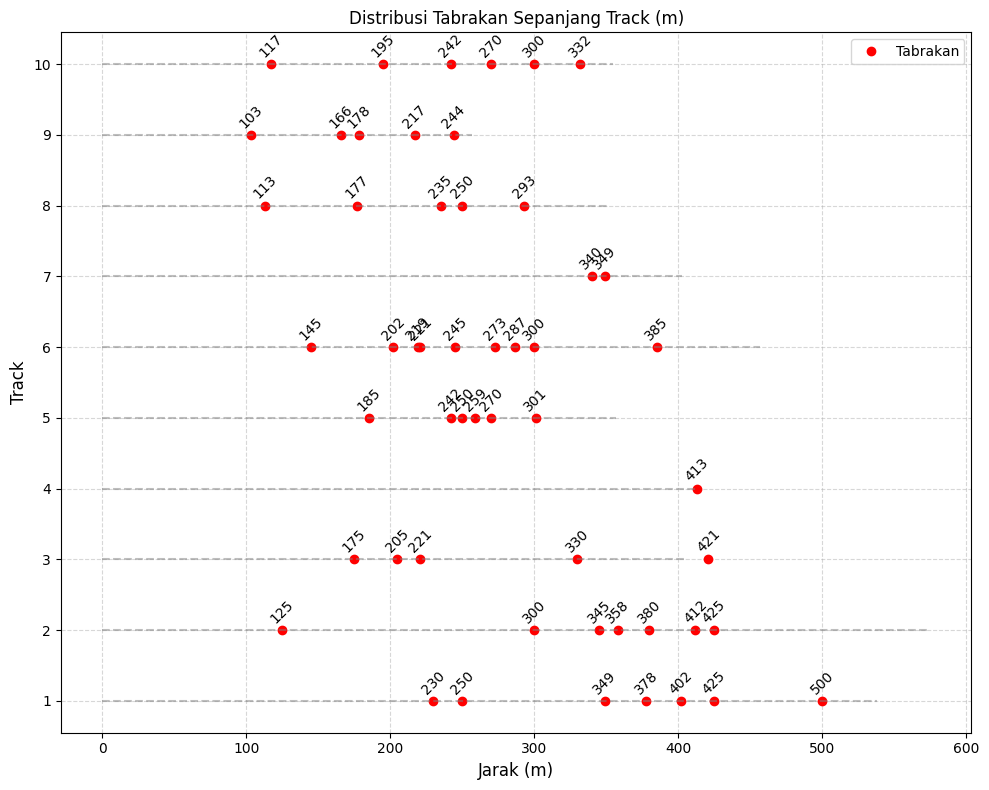

In [9]:
import matplotlib.pyplot as plt

# Example crash data for each track (you can expand this with all your data)
crash_data = {
    1: [230, 250, 349, 378, 402, 425, 500],
    2: [125, 300, 345, 358, 380, 412, 425],
    3: [175, 205, 221, 330, 421],
    4: [413],
    5: [185, 242, 250,259, 270, 301],
    6: [145, 202,219, 221, 245, 273, 287, 300, 385],
    7: [340, 349],
    8: [113, 177, 235, 250, 293],
    9: [103, 166, 178, 217, 244],
    10: [117, 195, 242, 270, 300, 332]
}

# Optional: Add track lengths for context (same keys as crash_data)
track_lengths = {
    1: 538, 2: 575, 3: 405, 4: 413, 5: 357,
    6: 457, 7: 403, 8: 351, 9: 257, 10: 355
}

fig, ax = plt.subplots(figsize=(10, 8))

# Plot crash points
for track, crashes in crash_data.items():
    ax.plot(crashes, [track]*len(crashes), 'ro', label='Tabrakan' if track == 1 else "")
    # Add text annotations for crash points
    for crash in crashes:
        ax.text(crash, track + 0.1, f'{crash}', fontsize=10, ha='center', rotation=45)
    ax.hlines(track, xmin=0, xmax=track_lengths[track], colors='gray', linestyles='dashed', alpha=0.5)

# Labels and formatting
ax.set_xlabel('Jarak (m)', fontsize=12)
ax.set_ylabel('Track', fontsize=12)
ax.set_title('Distribusi Tabrakan Sepanjang Track (m)', fontsize = 12)
ax.set_yticks(list(crash_data.keys()))
ax.legend(loc='upper right', fontsize=10)
ax.grid(True, which='both', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


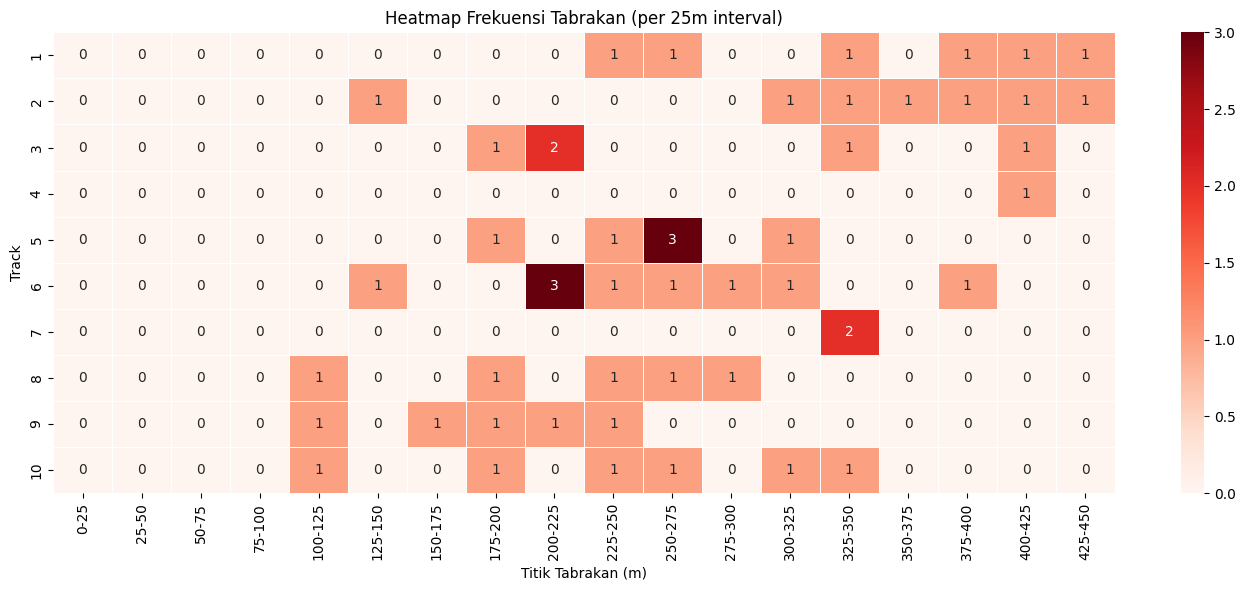

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Crash data
crash_data = {
    1: [230, 250, 349, 378, 402, 425, 500],
    2: [125, 300, 345, 358, 380, 412, 425],
    3: [175, 205, 221, 330, 421],
    4: [413],
    5: [185, 242, 250,259, 270, 301],
    6: [145, 202,219, 221, 245, 273, 287, 300, 385],
    7: [340, 349],
    8: [113, 177, 235, 250, 293],
    9: [103, 166, 178, 217, 244],
    10: [117, 195, 242, 270, 300, 332]
}

# Define bins (0 to 450 meters in steps of 25)
bins = np.arange(0, 475, 25)

# Initialize DataFrame
heatmap_data = pd.DataFrame(0, index=crash_data.keys(), columns=[f"{bins[i]}-{bins[i+1]}" for i in range(len(bins)-1)])

# Count crashes in each bin
for track, crashes in crash_data.items():
    bin_indices = np.digitize(crashes, bins) - 1  # subtract 1 to align with column index
    for idx in bin_indices:
        if 0 <= idx < len(heatmap_data.columns):  # make sure it's within bounds
            heatmap_data.iloc[track-1, idx] += 1

# Plot heatmap
plt.figure(figsize=(14, 6))
sns.heatmap(heatmap_data, annot=True, cmap="Reds", cbar=True, linewidths=.5)
plt.title("Heatmap Frekuensi Tabrakan (per 25m interval)")
plt.xlabel("Titik Tabrakan (m)")
plt.ylabel("Track")
plt.tight_layout()
plt.show()


# CPU Usage

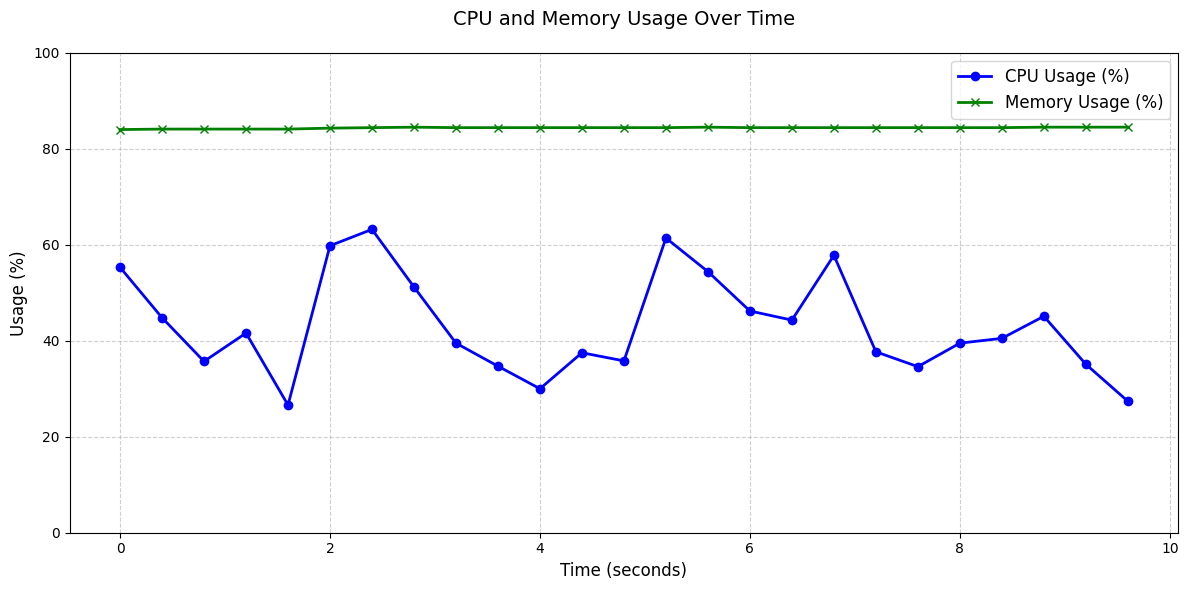

In [25]:
import matplotlib.pyplot as plt

# Data for CPU and memory usage
cpu_usage = [
    55.3, 44.8, 35.7, 41.6, 26.6, 59.8, 63.2, 51.2, 39.5, 34.7, 30.0, 37.5, 
    35.8, 61.4, 54.4, 46.2, 44.3, 57.8, 37.7, 34.6, 39.5, 40.5, 45.1, 35.1, 27.4
]
memory_usage = [
    84.0, 84.1, 84.1, 84.1, 84.1, 84.3, 84.4, 84.5, 84.4, 84.4, 84.4, 84.4, 
    84.4, 84.4, 84.5, 84.4, 84.4, 84.4, 84.4, 84.4, 84.4, 84.4, 84.5, 84.5, 84.5
]

# Time points (assuming the data was collected over 10 seconds)
time_points = [i * (10 / len(cpu_usage)) for i in range(len(cpu_usage))]

# Plot CPU and memory usage
plt.figure(figsize=(12, 6))
plt.plot(time_points, cpu_usage, label="CPU Usage (%)", color="blue", marker="o", linestyle="-", linewidth=2)
plt.plot(time_points, memory_usage, label="Memory Usage (%)", color="green", marker="x", linestyle="-", linewidth=2)

# Add labels, title, and legend
plt.xlabel("Time (seconds)", fontsize=12)
plt.ylabel("Usage (%)", fontsize=12)
plt.title("CPU and Memory Usage Over Time", fontsize=14, pad=20)
plt.legend(fontsize=12, loc='upper right')
plt.grid(True, linestyle="--", alpha=0.6)

# Adjust y-axis to better show both metrics
plt.ylim(0, 100)

# Show the plot
plt.tight_layout()
plt.show()

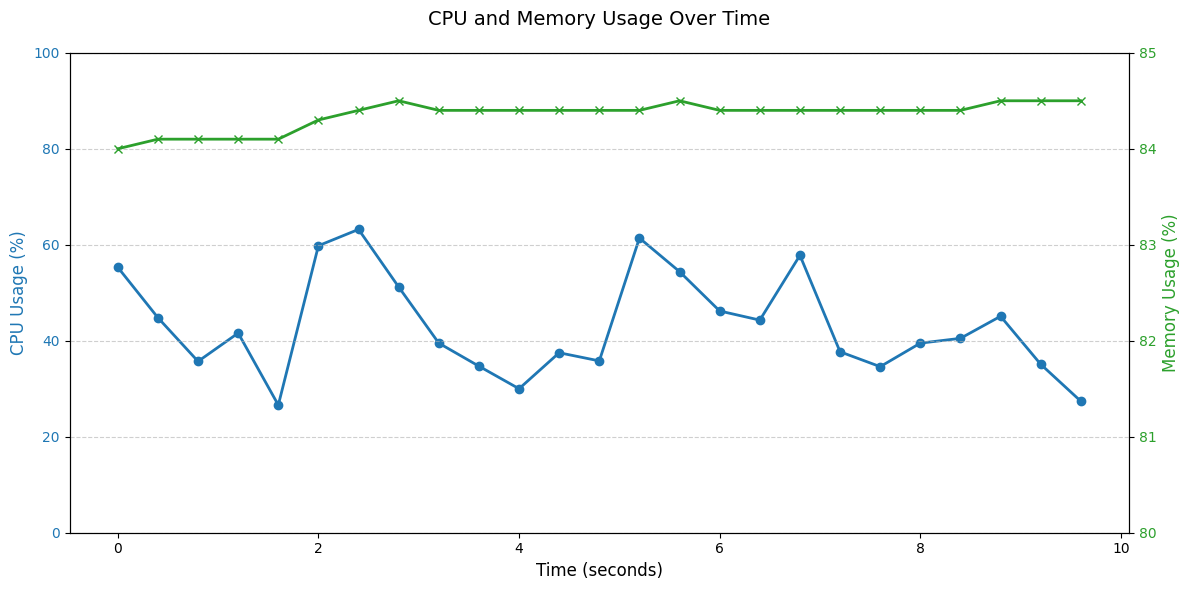

In [26]:
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel('Time (seconds)', fontsize=12)
ax1.set_ylabel('CPU Usage (%)', color=color, fontsize=12)
ax1.plot(time_points, cpu_usage, color=color, marker='o', linestyle='-', linewidth=2)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(0, 100)

ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Memory Usage (%)', color=color, fontsize=12)
ax2.plot(time_points, memory_usage, color=color, marker='x', linestyle='-', linewidth=2)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(80, 85)  # Adjusted to show memory variation better

plt.title('CPU and Memory Usage Over Time', fontsize=14, pad=20)
plt.grid(True, linestyle="--", alpha=0.6)
fig.tight_layout()
plt.show()